# Train a CNN on the color-based training set.
Assume training patches are in files on disk. See DF_Filter.011  
Here, work out loading them as needed for training.  
One issue is cuda.  
Another issue is the TensorFlow Data API.  

Directory structure is
* cache  
    * train  
        * 0  (green) 2680 files
        * 1   (blue) 3099 files
    * valid  
        * 0  (green) 266 files
        * 1   (blue) 311 files

Filename like F5..208 or F15.209.tif i.e. original_image.patch num.tif  
All prefixes are 3 characters with either one or two dots.  
Patch nums are per category.  
Each file holds a 224x224 patch of a color image.

In [1]:
import time
import os
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt

DIR_IMAGES_IN = "/home/jrm/Martinez/images/cache/"
PATCH_SIZE=224  # matches VGG
BLUE=1
GREEN=0


In [2]:
# TO DO: normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1./255)

In [22]:
# TO DO: load patches in random order
# TO DO: or, give patch files randome names
class patch_loader:
    def __init__(self):
        pass
    def load_pixel_array(self,filename):
        im = Image.open(filename)
        ima = np.array(im)   # convert to numpy
        return ima
    def load_dataset(self,path,tv,label,max_files=None):
        file_count=0
        images=[]
        labels=[]
        pstr = path+tv+'/'+str(label)+'/*.tif'
        fullpaths = glob.glob(pstr)
        # names = [os.path.basename(x) for x in fullpaths]
        for name in fullpaths:
            file_count += 1
            if file_count <= max_files:
                ima = self.load_pixel_array(name)
                images.append(ima)
                labels.append(label)
        return images,labels

In [29]:
X_train=[]
Y_train=[]
X_valid=[]
Y_valid=[]
pl = patch_loader()
greenX,greenY = pl.load_dataset(DIR_IMAGES_IN,'train',GREEN,max_files=10)
blueX, blueY =  pl.load_dataset(DIR_IMAGES_IN,'train',BLUE,max_files=10)
X_train = greenX + blueX
Y_train = greenY + blueY
# Required for tensorflow+
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid)
Y_valid = np.asarray(Y_valid)

In [30]:
print(Y_train)
print(type(X_train))
print(len(X_train))
print(X_train[0].shape)


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
<class 'numpy.ndarray'>
20
(224, 224, 3)


In [31]:
ACTIVATION="tanh"
NUM_CLASSES = 2
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,3]
cnn = keras.models.Sequential([
    kl.Conv2D(filters=64,kernel_size=7,activation=ACTIVATION,padding="SAME",
    input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(128,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(64,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(2,activation="softmax")
])
# 10 nodes in the output layer
# corresponds to 10 classes of MNIST clothes.
# cnn.layers[0].weights

In [32]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = cnn.fit(X_train,Y_train,epochs=EPOCHS,
                 validation_data=(X_valid,Y_valid))
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.7697 - accuracy: 0.6500
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 2.7745 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 3.7300 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 4.0830 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 3.1711 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 2.4955 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 2.5279 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 2.0135 - accuracy: 0.5000
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 1.8729 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 1.7324 - accuracy: 0.5000
Elapsed time: 26.14322590827942


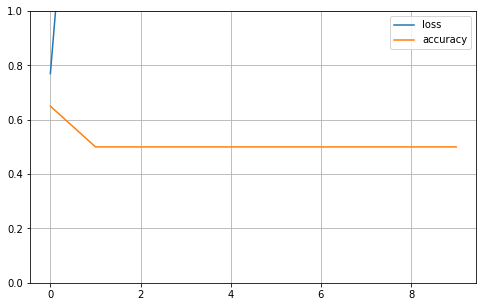

In [33]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

022-02-15 09:21:18.088128: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-15 09:21:18.088162: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Alien): /proc/driver/nvidia/version does not exist
2022-02-15 09:21:18.088620: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[I 09:22:14.940 NotebookApp] Saving file at /TumorI/DF_Filter.012.ipynb
